In [1]:
from __future__ import print_function, division
from builtins import range, input

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
# load in the data
df = pd.read_csv('/content/drive/MyDrive/Recommender_Systems/small_rating.csv')

In [4]:
df

,userId,movieId,rating,movie_idx
0,7307,1,4.5,10
1,7307,10,2.5,68
2,7307,19,3.5,143
3,7307,32,5.0,19
4,7307,39,4.5,85
...,...,...,...,...
5392020,5442,4993,5.0,33
5392021,5442,5349,3.0,115
5392022,5442,5378,4.0,211
5392023,5442,5449,4.0,1487


In [5]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

In [6]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [7]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty

In [8]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)

In [9]:
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)

In [10]:
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

In [11]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [12]:
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)

Epoch 1/15
33701/33701 [==============================] - 96s 3ms/step - loss: 0.6956 - mse: 0.6956 - val_loss: 0.6777 - val_mse: 0.6777
Epoch 2/15
33701/33701 [==============================] - 91s 3ms/step - loss: 0.6662 - mse: 0.6662 - val_loss: 0.6437 - val_mse: 0.6437
Epoch 3/15
33701/33701 [==============================] - 90s 3ms/step - loss: 0.6168 - mse: 0.6168 - val_loss: 0.5977 - val_mse: 0.5977
Epoch 4/15
33701/33701 [==============================] - 88s 3ms/step - loss: 0.5738 - mse: 0.5738 - val_loss: 0.5685 - val_mse: 0.5685
Epoch 5/15
33701/33701 [==============================] - 93s 3ms/step - loss: 0.5502 - mse: 0.5502 - val_loss: 0.5575 - val_mse: 0.5575
Epoch 6/15
33701/33701 [==============================] - 88s 3ms/step - loss: 0.5392 - mse: 0.5392 - val_loss: 0.5526 - val_mse: 0.5526
Epoch 7/15
33701/33701 [==============================] - 92s 3ms/step - loss: 0.5340 - mse: 0.5340 - val_loss: 0.5504 - val_mse: 0.5504
Epoch 8/15
33701/33701 [=================

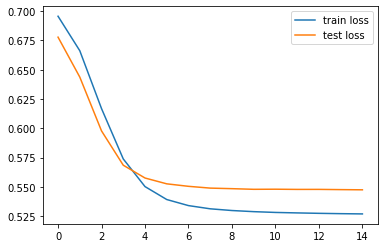

In [13]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()